In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mle-ese-mock/train (5).csv
/kaggle/input/mle-ese-mock/submission (6).csv
/kaggle/input/mle-ese-mock/test (4).csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

In [ ]:
# --------------------------------------------------
# 1) Load Data
# --------------------------------------------------
train = pd.read_csv("/kaggle/input/mle-ese-mock/train (5).csv")
test = pd.read_csv("/kaggle/input/mle-ese-mock/test (4).csv")

target = "quality_grade"

print(train.head())
print(train.describe().T)
print(train[target].value_counts())

In [ ]:
# --------------------------------------------------
# 2) Identify numeric & categorical columns
# --------------------------------------------------
num_cols = train.select_dtypes(include=np.number).columns.tolist()
cat_cols = train.select_dtypes(exclude=np.number).columns.tolist()
cat_cols.remove(target)
# --------------------------------------------------
# A) Boxplots BEFORE Imputation
# --------------------------------------------------
print("\nBoxplots for numeric columns (BEFORE imputation):")
plt.figure(figsize=(10, len(num_cols) * 2.2))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 1, i)
    plt.boxplot(train[col].dropna(), vert=False)
    plt.title(f"Boxplot - {col} (before imputation)")
plt.tight_layout()
plt.show()

In [ ]:
# --------------------------------------------------
# 3) Missing Value Imputation
# --------------------------------------------------
df = train.copy()

# numeric → median
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

# categorical → mode
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# B) Boxplots AFTER Imputation (BEFORE outlier removal)
# --------------------------------------------------
print("\nBoxplots for numeric columns (AFTER imputation):")
plt.figure(figsize=(10, len(num_cols) * 2.2))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 1, i)
    plt.boxplot(df[col], vert=False)
    plt.title(f"Boxplot - {col} (after imputation)")
plt.tight_layout()
plt.show()

In [ ]:
# --------------------------------------------------
# 4) Outlier Removal (IQR)
# --------------------------------------------------
df_no_out = df.copy()
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - 1.5 * IQR
    high = Q3 + 1.5 * IQR
    df_no_out = df_no_out[(df_no_out[col] >= low) & (df_no_out[col] <= high)]

print("After outlier removal:", df_no_out.shape)

In [ ]:
# --------------------------------------------------
# C) Boxplots AFTER Outlier Removal
# --------------------------------------------------
print("\nBoxplots for numeric columns (AFTER outlier removal):")
plt.figure(figsize=(10, len(num_cols) * 2.2))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 1, i)
    plt.boxplot(df_no_out[col], vert=False)
    plt.title(f"Boxplot - {col} (after outlier removal)")
plt.tight_layout()
plt.show()

# --------------------------------------------------

In [ ]:
# --------------------------------------------------
# 5) Label Encoding (Categorical + Target)
# --------------------------------------------------
le_dict = {}

for col in cat_cols:
    le = LabelEncoder()
    df_no_out[col] = le.fit_transform(df_no_out[col])
    le_dict[col] = le

target_le = LabelEncoder()
df_no_out[target] = target_le.fit_transform(df_no_out[target])
class_names = target_le.classes_     # VERY IMPORTANT

In [ ]:
# --------------------------------------------------
# 6) Train-Test Split + Scaling
# --------------------------------------------------
X = df_no_out.drop(columns=[target])
y = df_no_out[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# --------------------------------------------------
# 7) Random Forest + Hyperparameter Tuning
# --------------------------------------------------
rf = RandomForestClassifier(random_state=42)

param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [6, 10, None],
    "min_samples_split": [2, 4, 6],
    "min_samples_leaf": [1, 2, 3],
}


search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=15,
    scoring="accuracy",
    cv=3,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)
best_rf = search.best_estimator_

print("Best Params:", search.best_params_)

In [ ]:
# --------------------------------------------------
# 8) Evaluation
# --------------------------------------------------
pred = best_rf.predict(X_valid)
print("Accuracy:", accuracy_score(y_valid, pred))
print(classification_report(y_valid, pred))

In [ ]:
# --------------------------------------------------
# 9) Prepare Test Set for Submission
# --------------------------------------------------
test_imputed = test.copy()

# same imputation rules as training
for col in num_cols:
    if col in test_imputed.columns:
        test_imputed[col].fillna(df[col].median(), inplace=True)

# for col in cat_cols:
    # if col in test_imputed.columns:
       # test_imputed[col].fillna(df[col].mode()[0], inplace=True)
        #test_imputed[col] = le_dict[col].transform(test_imputed[col])
for col in cat_cols:
    if col in test_imputed.columns:
        
        # Fill missing values same as training
        test_imputed[col].fillna(df[col].mode()[0], inplace=True)

        # Replace unseen labels with "UNKNOWN"
        test_imputed[col] = test_imputed[col].apply(
            lambda x: x if x in le_dict[col].classes_ else "UNKNOWN"
        )

        # Add "UNKNOWN" to the encoder if not present
        if "UNKNOWN" not in le_dict[col].classes_:
            le_dict[col].classes_ = np.append(le_dict[col].classes_, "UNKNOWN")

        # Now safe to transform
        test_imputed[col] = le_dict[col].transform(test_imputed[col])

# scale using training scaler
X_test_scaled = scaler.transform(test_imputed)

# predict probabilities
probs = best_rf.predict_proba(X_test_scaled)

   id fruit_type  weight_g  diameter_cm color_grade  firmness_score  \
0   0      mango    169.20         6.65        dull            9.37   
1   1     banana    191.83         7.77      normal            6.63   
2   2      mango    180.29         6.34      normal            6.70   
3   3     banana    187.18         7.19     vibrant            6.99   
4   4     orange    185.25         8.12      normal            6.78   

   brix_level  acidity_ph  ripeness_index  bruise_area_pct  moisture_pct  \
0       15.88        3.77            0.93             0.00         79.43   
1       12.32        3.84            0.71             1.94         77.63   
2        8.31        3.66            0.63            10.52         80.19   
3       13.36        3.76            0.65             5.62         73.60   
4       11.13        4.06            0.64            11.53         77.13   

   shelf_life_days  harvest_age_days storage_type origin_region  quality_grade  
0                9                1

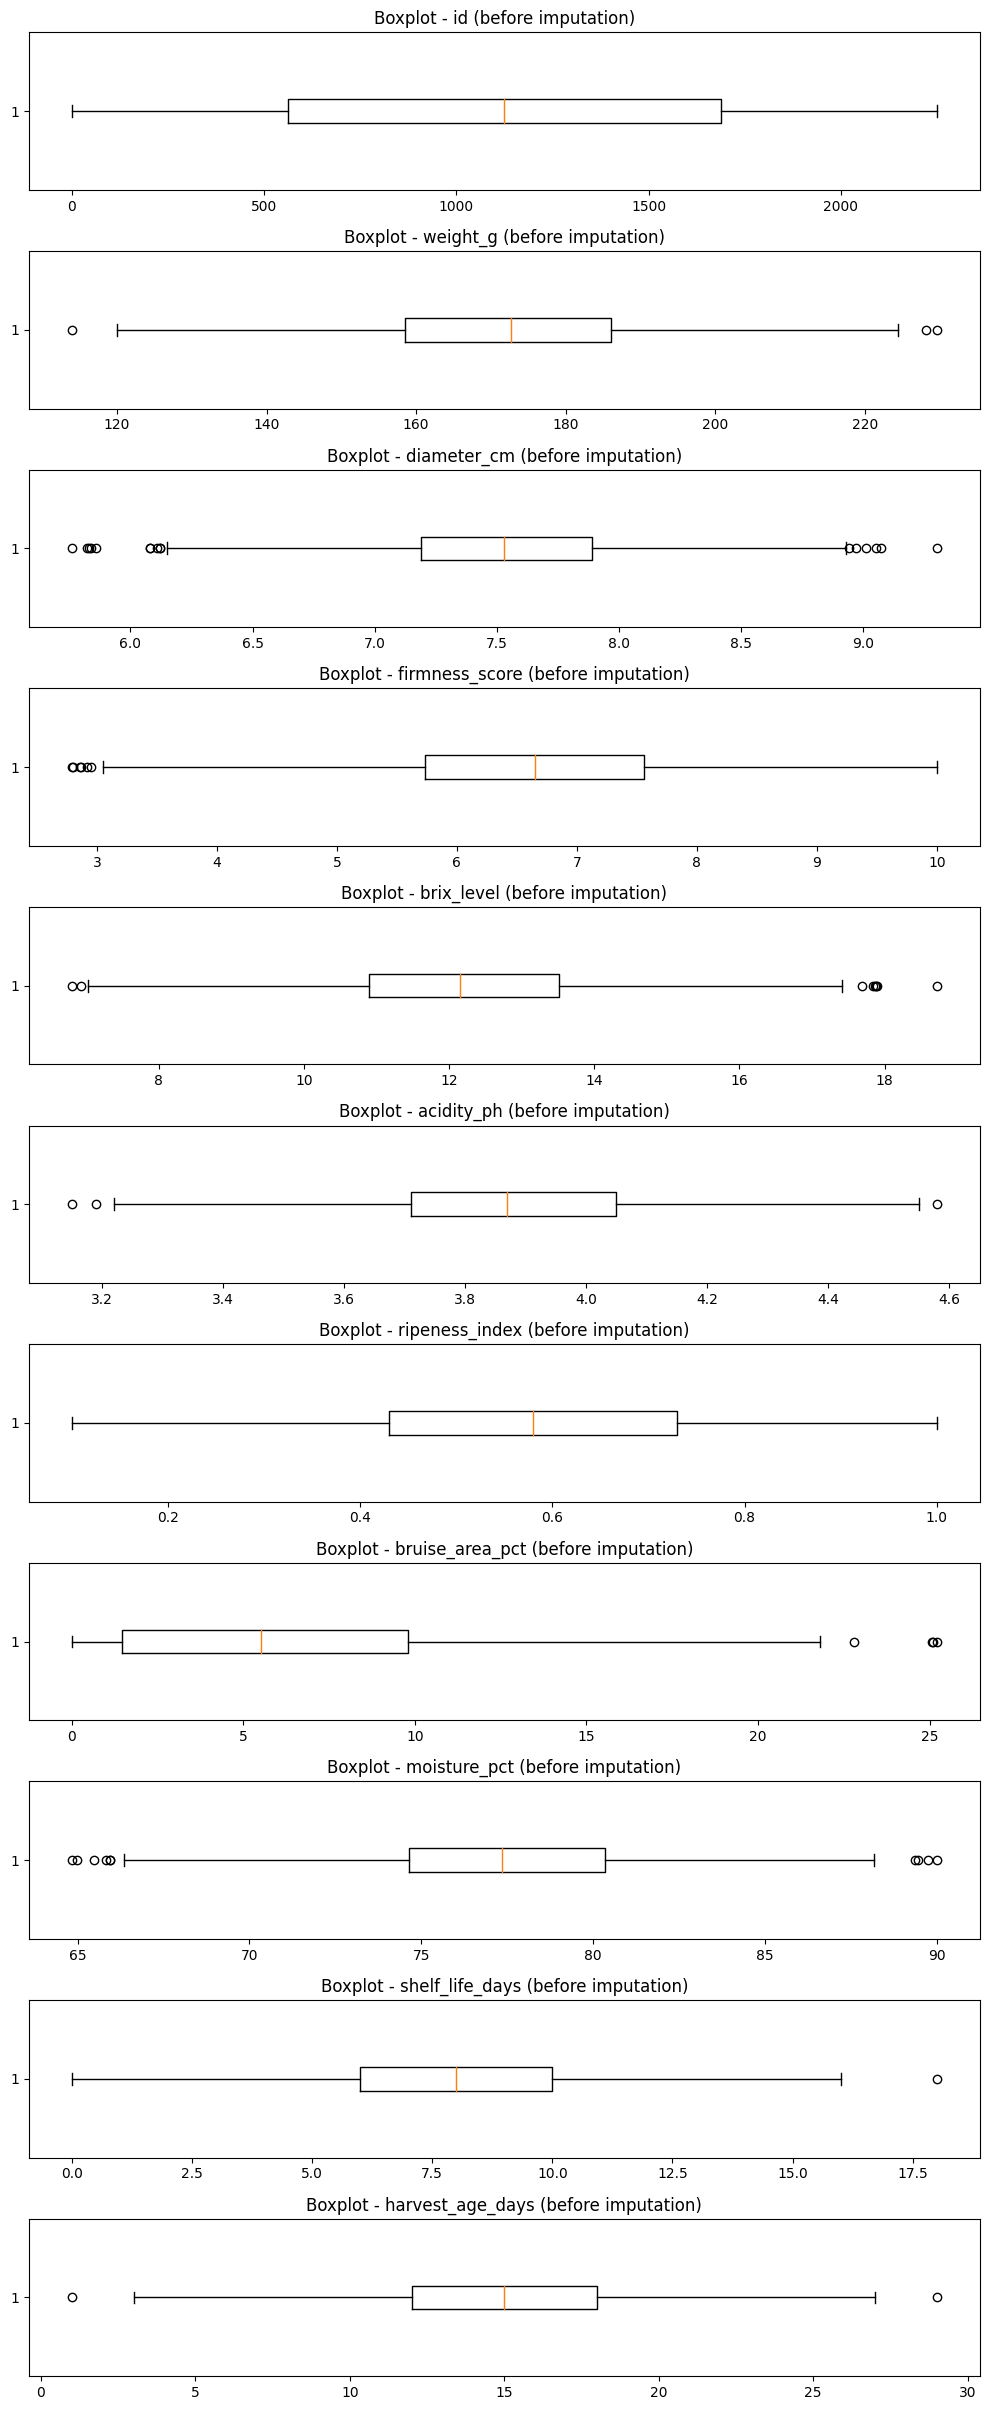

/tmp/ipykernel_47/3921404207.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_47/3921404207.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin


Boxplots for numeric columns (AFTER imputation):


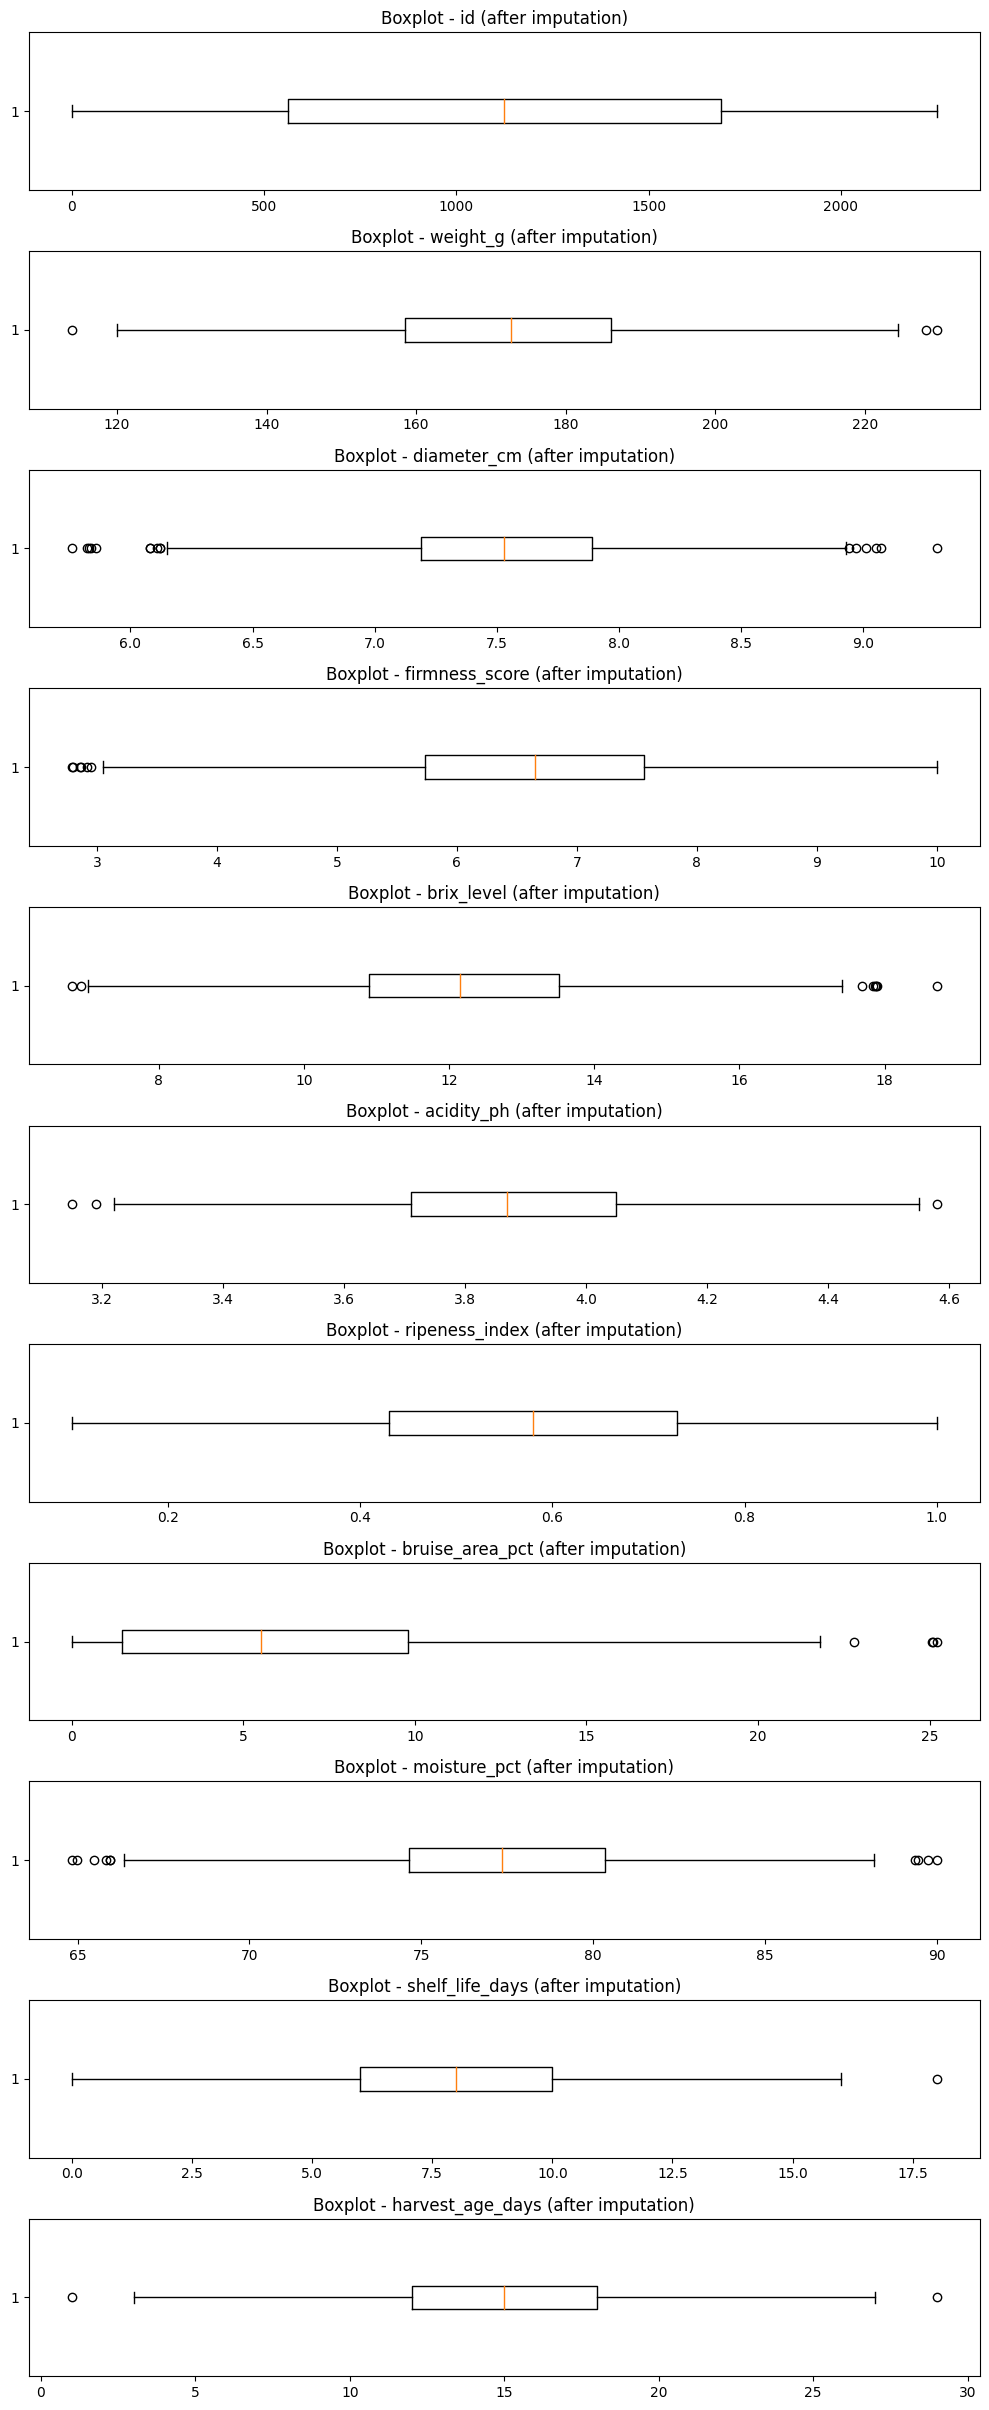

After outlier removal: (2198, 16)

Boxplots for numeric columns (AFTER outlier removal):


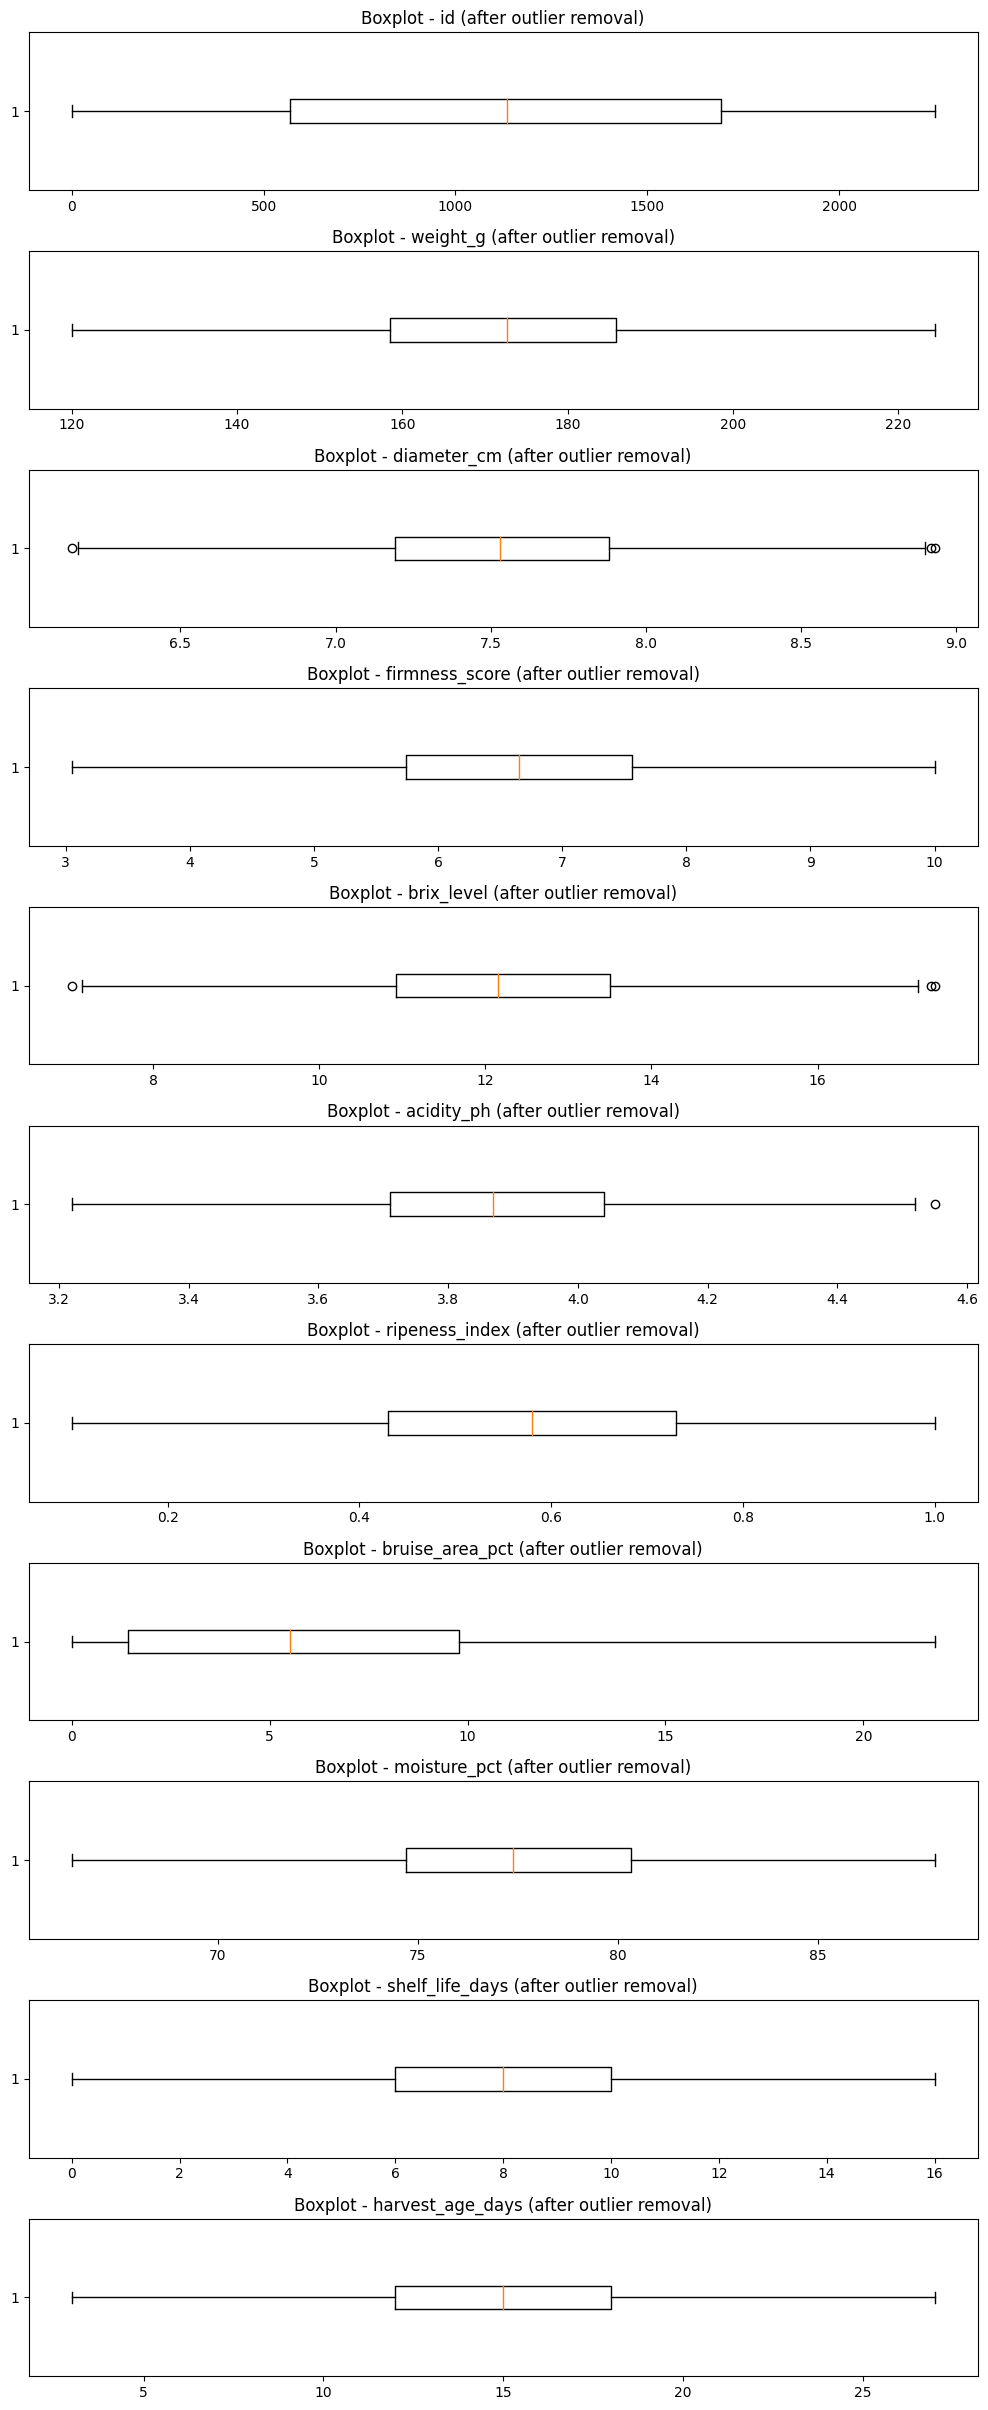

Best Params: {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 6}
Accuracy: 0.4340909090909091
              precision    recall  f1-score   support

           0       0.67      0.78      0.72        41
           1       0.57      0.71      0.63        42
           2       0.33      0.30      0.31        43
           3       0.29      0.29      0.29        45
           4       0.37      0.44      0.40        45
           5       0.43      0.27      0.33        45
           6       0.43      0.43      0.43        44
           7       0.35      0.41      0.38        44
           8       0.39      0.27      0.32        45
           9       0.49      0.50      0.49        44
          10       0.00      0.00      0.00         2

    accuracy                           0.43       440
   macro avg       0.39      0.40      0.39       440
weighted avg       0.43      0.43      0.42       440

Saved submission.csv


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_47/3921404207.py:163: FutureWarning: A value is t

In [ ]:
# --------------------------------------------------
# 10) FINAL CSV SUBMISSION (your request)
# --------------------------------------------------
sub = pd.DataFrame({
    "id": test["id"],
    f"Status_{class_names[1]}": probs[:, 1],
    f"Status_{class_names[2]}": probs[:, 2],
    f"Status_{class_names[3]}": probs[:, 3],
    f"Status_{class_names[4]}": probs[:, 4],
    f"Status_{class_names[5]}": probs[:, 5],
    f"Status_{class_names[6]}": probs[:, 6],
    f"Status_{class_names[7]}": probs[:, 7],
    f"Status_{class_names[8]}": probs[:, 8],
    f"Status_{class_names[9]}": probs[:, 9],
    f"Status_{class_names[0]}": probs[:, 0],
})

sub.to_csv("submission.csv", index=False)
print("Saved submission.csv")